# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

mingw_bin = "C:/msys64/mingw64/bin"
os.add_dll_directory(mingw_bin)
import ctypes
lin = ctypes.cdll.LoadLibrary("./cmake-build-debug/liblinear_model.dll")

lin.create_linear_model.argtypes = [ctypes.c_int32]
lin.create_linear_model.restype = ctypes.c_void_p

lin.predict_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_linear_model.restype = ctypes.c_float

lin.release_linear_model.argtypes = [ctypes.c_void_p]
lin.release_linear_model.restype = None

lin.train_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float), ctypes.c_int32, ctypes.c_float, ctypes.c_int32]
lin.train_linear_model.restype = None

lin.create_ovo_classifier.argtypes = [ctypes.c_int32]
lin.create_ovo_classifier.restype = ctypes.c_void_p

lin.train_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_int32), ctypes.c_int32, ctypes.c_int32, ctypes.c_float]
lin.train_ovo_classifier.restype = None

lin.predict_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_ovo_classifier.restype = ctypes.c_int32

lin.release_ovo_classifier.argtypes = [ctypes.c_void_p]
lin.release_ovo_classifier.restype = None



In [3]:
mlp = ctypes.cdll.LoadLibrary("./cmake-build-debug/libmlp.dll") 

mlp.create_mlp_model.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_int]
mlp.create_mlp_model.restype = ctypes.c_void_p

mlp.train_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_float,
    ctypes.c_int,
    ctypes.c_bool,
    ctypes.c_char_p, 
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int
]
mlp.predict_mlp_model.restype = ctypes.POINTER(ctypes.c_float)

mlp.predict_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_bool
]

mlp.release_mlp_model.argtypes = [ctypes.c_void_p]

mlp.get_confusion_matrix.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_int32)]
mlp.get_confusion_matrix.restype = None

mlp.evaluate_confusion_matrix.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_bool 
]
mlp.evaluate_confusion_matrix.restype = None

LOG_FUNC_TYPE = ctypes.CFUNCTYPE(None, ctypes.c_char_p)

@LOG_FUNC_TYPE
def logger_callback(msg):
    print(msg.decode())

# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [4]:
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([
      1,
      -1,
      -1
])


###  Classification linéaire:

In [5]:
model = lin.create_linear_model(2)
epochs = 1000
learning_rate = 0.03
batch_size = len(Y)
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
lin.train_linear_model(model, X_c, Y_c, epochs, learning_rate, batch_size)




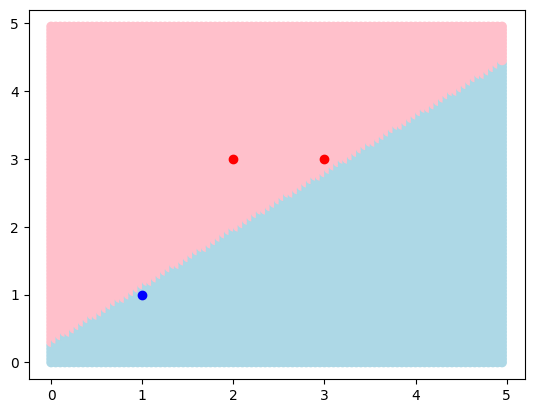

<Figure size 640x480 with 0 Axes>

In [6]:
predicted_colors = []
point_predicted = []
for x in np.arange(0, 5, 5.0/ 100.0):
  for y in np.arange(0, 5, 5.0/100.0):
    point = np.array([x, y], dtype=np.float32)
    point_predicted.append(point)
    predicted_colors.append('lightblue' if lin.predict_linear_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float))) == 1.0 else 'pink')
point_predicted = np.array(point_predicted)

plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(X[0, 0], X[0, 1], c='blue')
plt.scatter(X[1:3, 0], X[1:3, 1], c='red')
plt.show()
plt.clf()
lin.release_linear_model(model)



###  MLP:

In [7]:
layer_sizes = [2, 1]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)

In [8]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 1000
learning_rate = 0.03
batch_size = len(Y)

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True, b"tanh", X_c, Y_c, batch_size)



-956392784

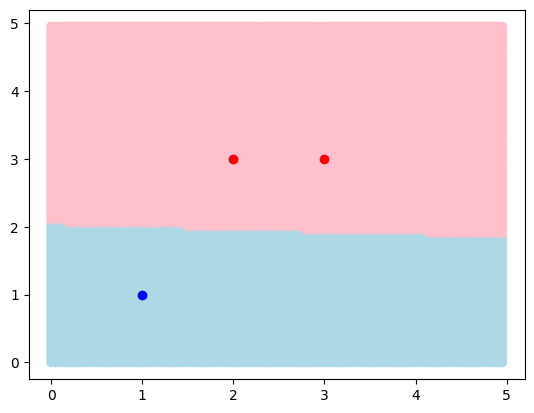

1

<Figure size 640x480 with 0 Axes>

In [9]:

predicted_colors = []
point_predicted = []

for x in np.arange(0, 5, 5.0 / 100.0):
    for y in np.arange(0, 5, 5.0 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output_ptr = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output = output_ptr[0]
        predicted_colors.append('lightblue' if output > 0 else 'pink')
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(X[0, 0], X[0, 1], c='blue')
plt.scatter(X[1:, 0], X[1:, 1], c='red')
plt.show()
plt.clf()
mlp.release_mlp_model(model)



### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [10]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

###  Classification linéaire:

In [11]:
model = lin.create_linear_model(2)
epochs = 10000
learning_rate = 0.03
batch_size = len(Y)
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
lin.train_linear_model(model, X_c, Y_c, epochs, learning_rate, batch_size)

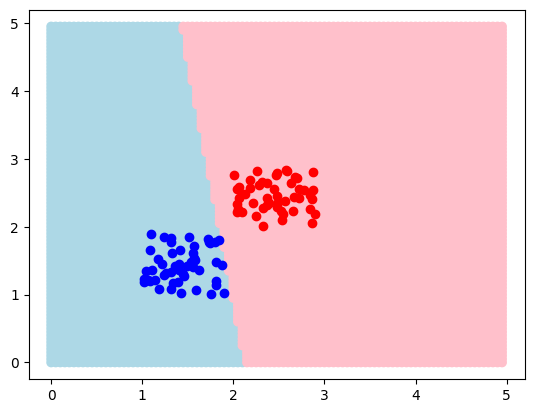

<Figure size 640x480 with 0 Axes>

In [12]:
predicted_colors = []
point_predicted = []
for x in np.arange(0, 5, 5.0/ 100.0):
  for y in np.arange(0, 5, 5.0/100.0):
    point = np.array([x, y], dtype=np.float32)
    point_predicted.append(point)
    prediction = lin.predict_linear_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)))
    predicted_colors.append('lightblue' if prediction > 0 else 'pink')
point_predicted = np.array(point_predicted)

plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()
lin.release_linear_model(model)



###  MLP:

In [13]:
layer_sizes = [2, 1]  # input=2, hidden=6, output=1
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)

In [14]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 1000
learning_rate = 0.03
batch_size = len(Y)

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True, b"tanh", X_c, Y_c, batch_size)



-956392784

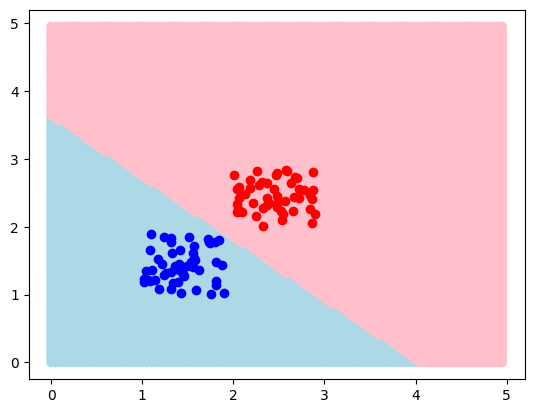

1

<Figure size 640x480 with 0 Axes>

In [15]:

predicted_colors = []
point_predicted = []

for x in np.arange(0, 5, 5.0 / 100.0):
    for y in np.arange(0, 5, 5.0 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output_ptr = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output = output_ptr[0]
        predicted_colors.append('lightblue' if output > 0 else 'pink')
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()
mlp.release_mlp_model(model)



### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

In [16]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

In [17]:
layer_sizes = [2, 2, 1]  # input=2, hidden=6, output=1
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)

In [18]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 1000
learning_rate = 0.05
batch_size = len(Y)

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True,  b"tanh", X_c, Y_c, batch_size)


-956392784

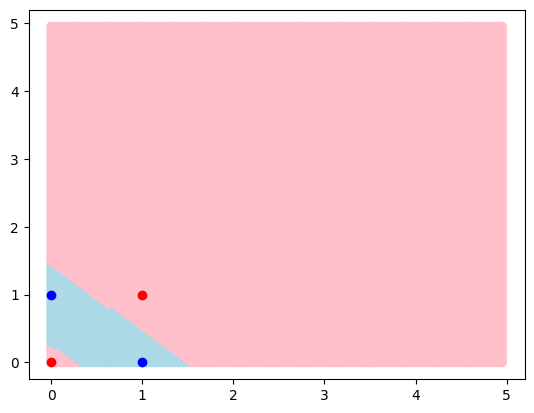

1

<Figure size 640x480 with 0 Axes>

In [19]:
predicted_colors = []
point_predicted = []

for x in np.arange(0, 5, 5.0 / 100.0):
    for y in np.arange(0, 5, 5.0 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output_ptr = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output = output_ptr[0]
        predicted_colors.append('lightblue' if output > 0 else 'pink')
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()
mlp.release_mlp_model(model)


























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

In [23]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

In [28]:
layer_sizes = [2, 4, 1]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)

In [29]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 10000
learning_rate = 0.03
batch_size = 64

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True,  b"tanh", X_c, Y_c, batch_size)

-956392784

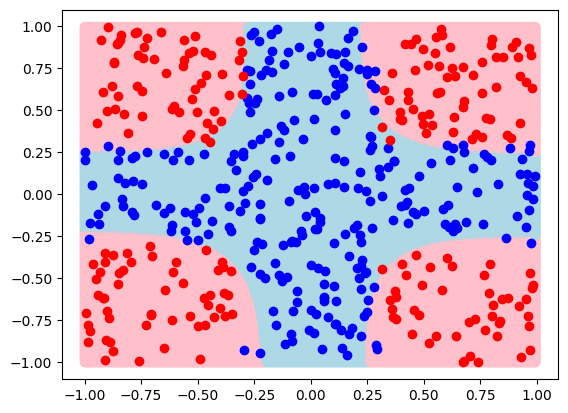

1

<Figure size 640x480 with 0 Axes>

In [30]:
predicted_colors = []
point_predicted = []

for x in np.arange(-1, 1, 0.5 / 100.0):
    for y in np.arange(-1, 1, 0.5 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output_ptr = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output = output_ptr[0]
        predicted_colors.append('lightblue' if output > 0 else 'pink')
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()
mlp.release_mlp_model(model)


### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

In [31]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [0, 0, 0]for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

print(Y)

[[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [32]:
Y_class = np.argmax(Y, axis=1).astype(np.int32)

Y_class = Y_class.astype(np.int32)

num_samples = len(Y_class)
dim = 2
num_classes = 3
X_c = X.astype(np.float32).flatten()
Y_c = Y_class.astype(np.int32)
print(Y)

[[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [33]:
model = lin.create_ovo_classifier(dim, num_classes)
epochs = 10000
learning_rate = 0.03
lin.train_ovo_classifier(model, X_c.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), Y_c.ctypes.data_as(ctypes.POINTER(ctypes.c_int32)), num_samples, epochs, learning_rate)


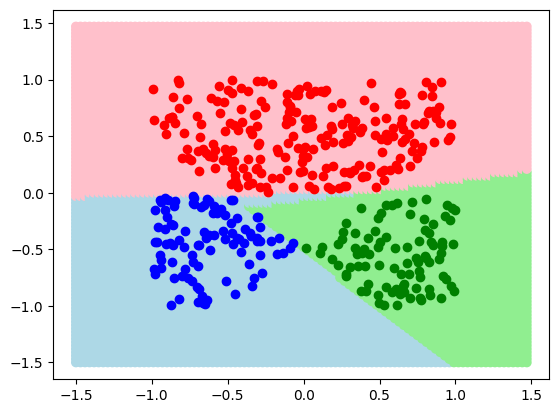

<Figure size 640x480 with 0 Axes>

In [34]:
predicted_colors = []
point_predicted = []
colors_map = {0: 'lightblue', 1: 'pink', 2: 'lightgreen'}

for x in np.arange(-1.5, 1.5, 3.0 / 100.0):
    for y in np.arange(-1.5, 1.5, 3.0 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        point_predicted.append(point)
        pred_class = lin.predict_ovo_classifier(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)))
        predicted_colors.append(colors_map[pred_class])

point_predicted = np.array(point_predicted)

lin.release_ovo_classifier(model)

plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

### MLP:

In [39]:
layer_sizes = [2, 3]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)

In [40]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 1000
learning_rate = 0.03
batch_size = 32

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True,  b"tanh",X_c, Y_c, batch_size)

-956392784

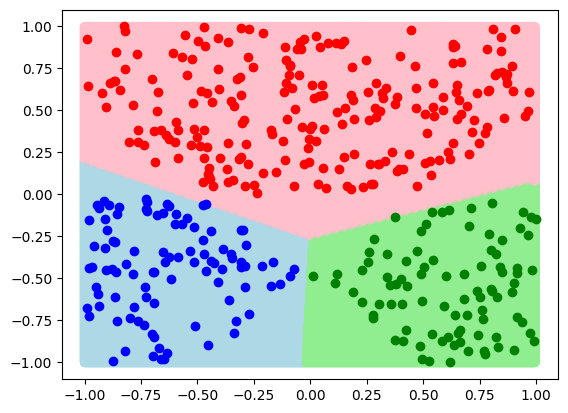

1

<Figure size 640x480 with 0 Axes>

In [41]:
predicted_colors = []
point_predicted = []

colors_map = {0: 'lightblue', 1: 'pink', 2: 'lightgreen'}

for x in np.arange(-1, 1, 0.5 / 100.0):
    for y in np.arange(-1, 1, 0.5 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output_array = ctypes.cast(output, ctypes.POINTER(ctypes.c_float * layer_sizes[-1])).contents
        output = list(output_array)
        color = 0
        for i in range(len(output)):
            if output[i] == max(output):
                color = i


        predicted_colors.append(colors_map[color])
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()
mlp.release_mlp_model(model)


### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK

In [50]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [0, 0, 1] for p in X])

In [51]:
layer_sizes = [2, 256, 128, 64, 3]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)
mlp.set_logger(logger_callback)

417664960

In [ ]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X_flat = X.flatten()
X_c = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_c = Y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
epochs = 1000
learning_rate = 0.02
batch_size = 32

mlp.train_mlp_model(model, X_c, Y_c, len(X), epochs, learning_rate, batch_size, True, b"tanh", X_c, Y_c, batch_size)

Epoch 100: acc = 84.38%, loss = 0.4583
Epoch 200: acc = 71.88%, loss = 0.5262
Epoch 300: acc = 81.25%, loss = 0.5238
Epoch 400: acc = 90.62%, loss = 0.3996
Epoch 500: acc = 84.38%, loss = 0.3787
Epoch 600: acc = 87.50%, loss = 0.3856
Epoch 700: acc = 84.38%, loss = 0.3961
Epoch 800: acc = 90.62%, loss = 0.3530
Epoch 900: acc = 84.38%, loss = 0.3694
Epoch 1000: acc = 87.50%, loss = 0.2861


-956392784

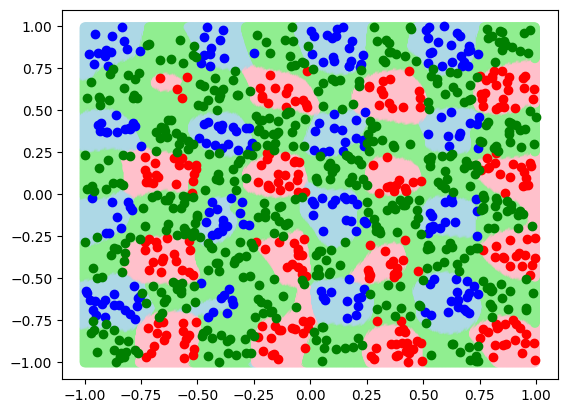

1

<Figure size 640x480 with 0 Axes>

In [53]:
predicted_colors = []
point_predicted = []

colors_map = {0: 'lightblue', 1: 'pink', 2: 'lightgreen'}

for x in np.arange(-1, 1, 0.5 / 100.0):
    for y in np.arange(-1, 1, 0.5 / 100.0):
        point = np.array([x, y], dtype=np.float32)
        output = mlp.predict_mlp_model(model, point.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
        output_array = ctypes.cast(output, ctypes.POINTER(ctypes.c_float * layer_sizes[-1])).contents
        output = list(output_array)
        color = 0
        for i in range(len(output)):
            if output[i] == max(output):
                color = i


        predicted_colors.append(colors_map[color])
        point_predicted.append(point)

point_predicted = np.array(point_predicted)

# Affichage
plt.scatter(point_predicted[:, 0], point_predicted[:, 1], c=predicted_colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()
mlp.release_mlp_model(model)


## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

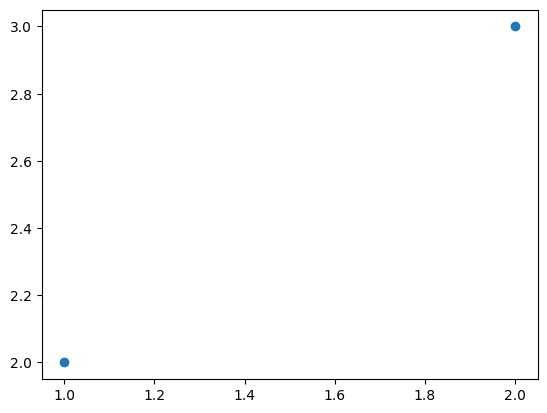

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

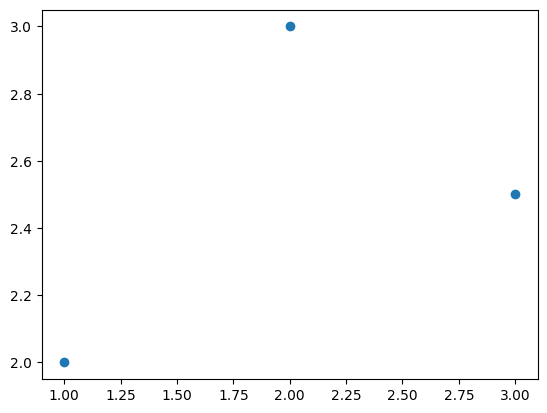

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [ ]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>